### Noise regularised NNGPs on a toy 1d problem

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return np.sin(2 * np.pi * x)

### Samples from noisy NNGP prior as a function of the noise

In [28]:
import tensorflow as tf
import nngp
import gpr

mu_2 = 1.5
num_points = 100
x = np.linspace(0, 1, num_points).reshape((100,1))

with tf.Session() as sess:
    nngp_kernel = nngp.NNGPKernel(depth=20, weight_var=2, bias_var=0.0, 
                             mu_2=mu_2, nonlin_fn='relu')
    input1 = tf.identity(tf.placeholder(tf.float64, [num_points, 1],
                         name="x_train1"))
    input2 = tf.identity(tf.placeholder(tf.float64, [num_points, 1],
                         name="x_train2"))
    K = sess.run(nngp_kernel.k_full(input1, input2), feed_dict={input1:x, input2:sinusoidal(x)})

In [29]:
K

array([[0.31838171, 0.31838171, 0.31838171, ..., 0.31838171, 0.31838171,
        0.31838171],
       [0.31838171, 0.31838171, 0.31838171, ..., 0.31838171, 0.31838171,
        0.31838171],
       [0.31838171, 0.31838171, 0.31838171, ..., 0.31838171, 0.31838171,
        0.31838171],
       ...,
       [0.31838171, 0.31838171, 0.31838171, ..., 0.31838171, 0.31838171,
        0.31838171],
       [0.31838171, 0.31838171, 0.31838171, ..., 0.31838171, 0.31838171,
        0.31838171],
       [0.31838171, 0.31838171, 0.31838171, ..., 0.31838171, 0.31838171,
        0.31838171]])

### Fitting GP to a set of training points

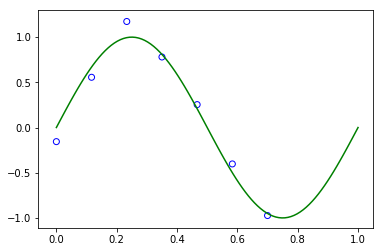

In [9]:
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")

In [ ]:
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

model = GaussianProcessRegressor(kernel=RBF(np.array([1., 15.])), beta=100)
model.fit(x_train, y_train)

y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr")
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.show()